# DROP ROBOT FROM MODELS

# Data Import

In [129]:
%%time

import os
import math
import datetime
import numpy as np
import pandas as pd
from copy import copy
from tqdm import tqdm

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

Wall time: 0 ns


In [130]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

In [131]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [132]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

('fahad', 'C:/Users/fahad/')

## Importing Data

In [133]:
main_path = r'./Data/'
# path = r'./Data/3. merged data/'
path = r'./Data/3. merged data/'
export_path = './Data/4. results/'


# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)

os.listdir(path)

['Graminor_2019_Simps.csv',
 'Graminor_2019_Trapz.csv',
 'Graminor_2020_Simps.csv',
 'Graminor_2020_Trapz.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2019_Trapz.csv',
 'Masbasis_2020_Simps.csv',
 'Masbasis_2020_Trapz.csv',
 'Robot_2020_Simps.csv',
 'Robot_2020_Trapz.csv',
 'Staur_2019_Simps.csv',
 'Staur_2019_Trapz.csv',
 'Staur_2020_Simps.csv',
 'Staur_2020_Trapz.csv']

In [134]:
# Making dictionary of files in each folder, in case there are multiple types of data
dict_paths = {}
def explore(starting_path):
    for dirpath, dirnames, filenames in os.walk(starting_path):
        dict_paths[dirpath.split('/')[-2]] = filenames
#     pprint(dict_paths)
explore(path)

# Data Preparation
## Creating list of complete files

In [135]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
files_list

14 files found in the directory


['Graminor_2019_Simps.csv',
 'Graminor_2019_Trapz.csv',
 'Graminor_2020_Simps.csv',
 'Graminor_2020_Trapz.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2019_Trapz.csv',
 'Masbasis_2020_Simps.csv',
 'Masbasis_2020_Trapz.csv',
 'Robot_2020_Simps.csv',
 'Robot_2020_Trapz.csv',
 'Staur_2019_Simps.csv',
 'Staur_2019_Trapz.csv',
 'Staur_2020_Simps.csv',
 'Staur_2020_Trapz.csv']

# Data Checking/control

## Check for duplicate filenames

In [136]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 14
Number of unique file names are: 14
There is/are 0 duplicate file name/names.


# Importing data files to Pandas

In [137]:
   
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

Graminor_2019_Simps ===== (600, 143)
Graminor_2019_Trapz ===== (600, 143)
Graminor_2020_Simps ===== (800, 143)
Graminor_2020_Trapz ===== (800, 143)
Masbasis_2019_Simps ===== (528, 144)
Masbasis_2019_Trapz ===== (528, 144)
Masbasis_2020_Simps ===== (659, 146)
Masbasis_2020_Trapz ===== (659, 146)
Robot_2020_Simps ===== (96, 145)
Robot_2020_Trapz ===== (96, 145)
Staur_2019_Simps ===== (1328, 127)
Staur_2019_Trapz ===== (1328, 127)
Staur_2020_Simps ===== (1504, 124)
Staur_2020_Trapz ===== (1504, 124)
Wall time: 542 ms


In [138]:
all_df_simps = [x for x in all_df if 'Simps' in x]
all_df_trapz = [x for x in all_df if 'Trapz' in x]
all_df_simps, all_df_trapz

(['Graminor_2019_Simps',
  'Graminor_2020_Simps',
  'Masbasis_2019_Simps',
  'Masbasis_2020_Simps',
  'Robot_2020_Simps',
  'Staur_2019_Simps',
  'Staur_2020_Simps'],
 ['Graminor_2019_Trapz',
  'Graminor_2020_Trapz',
  'Masbasis_2019_Trapz',
  'Masbasis_2020_Trapz',
  'Robot_2020_Trapz',
  'Staur_2019_Trapz',
  'Staur_2020_Trapz'])

Old  
Masbasis_2019 ===== (528, 160)  
Masbasis_2020 ===== (637, 162)  
Robot_2020 ===== (96, 162)  
Staur_2019 ===== (162, 160)  

In [139]:
print(f'Total imported {len(all_df)}')
all_df

Total imported 14


['Graminor_2019_Simps',
 'Graminor_2019_Trapz',
 'Graminor_2020_Simps',
 'Graminor_2020_Trapz',
 'Masbasis_2019_Simps',
 'Masbasis_2019_Trapz',
 'Masbasis_2020_Simps',
 'Masbasis_2020_Trapz',
 'Robot_2020_Simps',
 'Robot_2020_Trapz',
 'Staur_2019_Simps',
 'Staur_2019_Trapz',
 'Staur_2020_Simps',
 'Staur_2020_Trapz']

# Finding yield columns

## Importing Weather variables, yield columns, spectral indices, base indices columsn list

In [140]:
a_file = open(main_path+'vollebekk_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to python format
weather_cols_vollebekk = json.loads(output_str)
a_file.close()

pprint(len(weather_cols_vollebekk))

100


In [141]:
a_file = open(main_path+'staur_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to python format
weather_cols_staur = json.loads(output_str)
a_file.close()

pprint(len(weather_cols_staur))

80


In [142]:
a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

['GrainYield', 'CodeName', 'Block', 'Line', 'Entry', 'Replicates', 'Maturity_Date', 'Days2Maturity', 'Pedigree', 'Lodging', 'Heading_Date', 'iBlock', 'Days2Heading', 'Name']


In [143]:
a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
spectral_indices = json.loads(output_str)
a_file.close()
print(spectral_indices)

['NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']


In [144]:
a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

['Blue', 'Green', 'Red', 'RedEdge', 'NIR']


## Defining categories of features

In [145]:
# ToDo: Add check for duplicate columns in the df

base_indices

spectral_indices

# Staur weather columns are all also present in Vollebekk weather so they can be use as general weather features
weather_features = weather_cols_staur.copy()

environment_var = weather_features + ['Staur_Env', 'Vollebekk_Env']

yield_cols

# Counter for location of column in columns list

# Dict for saving the name and location of the yield column/s
loc_yield_cols = {}
for df in all_df:
    loc = 0
    for cols in locals()[df].columns.tolist():
        for y_col in yield_cols:
            if not cols.find(y_col):
                loc_yield_cols[cols+'_'+df] = loc
                print(f'\"{cols}\" column in {df} is the yield column\n as it contains the text \"{y_col}\". It is located at location {loc}')
        loc += 1

    yield_cols_found = list(loc_yield_cols.keys())
    target_cols=yield_cols_found[0]
loc_yield_cols

"GrainYield" column in Graminor_2019_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Block" column in Graminor_2019_Simps is the yield column
 as it contains the text "Block". It is located at location 2
"iBlock" column in Graminor_2019_Simps is the yield column
 as it contains the text "iBlock". It is located at location 3
"Entry" column in Graminor_2019_Simps is the yield column
 as it contains the text "Entry". It is located at location 4
"Name" column in Graminor_2019_Simps is the yield column
 as it contains the text "Name". It is located at location 5
"Pedigree" column in Graminor_2019_Simps is the yield column
 as it contains the text "Pedigree". It is located at location 40
"GrainYield" column in Graminor_2019_Trapz is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Block" column in Graminor_2019_Trapz is the yield column
 as it contains the text "Block". It is located at location 2
"iBlock" colu

 as it contains the text "Block". It is located at location 44
"GrainYield" column in Staur_2020_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Block" column in Staur_2020_Simps is the yield column
 as it contains the text "Block". It is located at location 2
"iBlock" column in Staur_2020_Simps is the yield column
 as it contains the text "iBlock". It is located at location 3
"Entry" column in Staur_2020_Simps is the yield column
 as it contains the text "Entry". It is located at location 4
"Name" column in Staur_2020_Simps is the yield column
 as it contains the text "Name". It is located at location 5
"Pedigree" column in Staur_2020_Simps is the yield column
 as it contains the text "Pedigree". It is located at location 6
"Lodging" column in Staur_2020_Simps is the yield column
 as it contains the text "Lodging". It is located at location 41
"GrainYield" column in Staur_2020_Trapz is the yield column
 as it contains the text "GrainYield"

{'GrainYield_Graminor_2019_Simps': 1,
 'Block_Graminor_2019_Simps': 2,
 'iBlock_Graminor_2019_Simps': 3,
 'Entry_Graminor_2019_Simps': 4,
 'Name_Graminor_2019_Simps': 5,
 'Pedigree_Graminor_2019_Simps': 40,
 'GrainYield_Graminor_2019_Trapz': 1,
 'Block_Graminor_2019_Trapz': 2,
 'iBlock_Graminor_2019_Trapz': 3,
 'Entry_Graminor_2019_Trapz': 4,
 'Name_Graminor_2019_Trapz': 5,
 'Pedigree_Graminor_2019_Trapz': 40,
 'GrainYield_Graminor_2020_Simps': 1,
 'Block_Graminor_2020_Simps': 2,
 'iBlock_Graminor_2020_Simps': 3,
 'Entry_Graminor_2020_Simps': 4,
 'Name_Graminor_2020_Simps': 5,
 'Pedigree_Graminor_2020_Simps': 40,
 'GrainYield_Graminor_2020_Trapz': 1,
 'Block_Graminor_2020_Trapz': 2,
 'iBlock_Graminor_2020_Trapz': 3,
 'Entry_Graminor_2020_Trapz': 4,
 'Name_Graminor_2020_Trapz': 5,
 'Pedigree_Graminor_2020_Trapz': 40,
 'GrainYield_Masbasis_2019_Simps': 1,
 'Replicates_Masbasis_2019_Simps': 2,
 'Block_Masbasis_2019_Simps': 3,
 'Name_Masbasis_2019_Simps': 4,
 'Line_Masbasis_2019_Simps': 5,

# Dropping unnecessary columns


In [146]:
# Dropping unnecessary columns

for df in all_df:
    temp_df = locals()[df].copy()
    print(df, temp_df.shape)
    locals()[df] = temp_df[base_indices+spectral_indices+environment_var+['Name','GrainYield']]

Graminor_2019_Simps (600, 143)
Graminor_2019_Trapz (600, 143)
Graminor_2020_Simps (800, 143)
Graminor_2020_Trapz (800, 143)
Masbasis_2019_Simps (528, 144)
Masbasis_2019_Trapz (528, 144)
Masbasis_2020_Simps (659, 146)
Masbasis_2020_Trapz (659, 146)
Robot_2020_Simps (96, 145)
Robot_2020_Trapz (96, 145)
Staur_2019_Simps (1328, 127)
Staur_2019_Trapz (1328, 127)
Staur_2020_Simps (1504, 124)
Staur_2020_Trapz (1504, 124)


# Dealing with Nan values

In [147]:
# For displaying max rows in series
pd.options.display.max_rows = 1000

Staur_2020_Simps.isna().sum()

Blue                                                         0
Green                                                        0
Red                                                          0
RedEdge                                                      0
NIR                                                          0
NDVI                                                         0
MTCI                                                         0
DVI                                                          0
GDVI                                                         0
MTCI_CI                                                      0
EXG                                                          0
EXGR                                                         0
RDVI                                                         0
TDVI                                                         0
GNDVI                                                        0
NDRE                                                   

## Dropping Missing values

In [148]:
# Dropping rows with missing value in any column

for df in all_df:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df.dropna(axis=0)
    print(temp_df.shape[0] - locals()[df].shape[0], ' rows dropped in ', df)
#     print(locals()[df].shape[0])

1  rows dropped in  Graminor_2019_Simps
1  rows dropped in  Graminor_2019_Trapz
1  rows dropped in  Graminor_2020_Simps
1  rows dropped in  Graminor_2020_Trapz
6  rows dropped in  Masbasis_2019_Simps
6  rows dropped in  Masbasis_2019_Trapz
116  rows dropped in  Masbasis_2020_Simps
116  rows dropped in  Masbasis_2020_Trapz
8  rows dropped in  Robot_2020_Simps
8  rows dropped in  Robot_2020_Trapz
0  rows dropped in  Staur_2019_Simps
0  rows dropped in  Staur_2019_Trapz
568  rows dropped in  Staur_2020_Simps
568  rows dropped in  Staur_2020_Trapz


Old  
6  rows dropped in  Masbasis_2019  
522  
94  rows dropped in  Masbasis_2020  
543  
0  rows dropped in  Robot_2020  
96  
0  rows dropped in  Staur_2019  
162  

# Correlation

In [149]:
# # Step 1 - Make a scatter plot with square markers, set column names as labels

# def heatmap(x, y, size):
#     fig_size=(15,10)

#     fig, ax = plt.subplots(figsize=fig_size)
    
#     # Mapping from column names to integer coordinates
#     x_labels = [v for v in x.unique()]
#     y_labels = [v for v in y.unique()]
#     x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
#     y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
#     size_scale = 50
#     ax.scatter(
#         x=x.map(x_to_num), # Use mapping for x
#         y=y.map(y_to_num), # Use mapping for y
#         s=size * size_scale, # Vector of square sizes, proportional to size parameter
#         marker='s' # Use square as scatterplot marker
#     )
    
#     # Show column labels on the axes
#     ax.set_xticks([x_to_num[v] for v in x_labels])
#     ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
#     ax.set_yticks([y_to_num[v] for v in y_labels])
#     ax.set_yticklabels(y_labels)
#     ax.grid(False, 'major')
#     ax.grid(True, 'minor')
#     ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
#     ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    


In [150]:
# for df in all_df:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df

    
#     fig, ax = plt.subplots(figsize=(10, 8))
#     # mask
#     mask = np.triu(np.ones_like(data, dtype=np.bool))
#     # adjust mask and df
#     mask = mask[1:, :-1]
#     corr = data.iloc[1:,:-1].copy()
#     # plot heatmap
#     print('u1')

#     sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
#                vmin=-1, vmax=1, cbar_kws={"shrink": .8})
#     # yticks
#     print('u2')
#     # plt.yticks(rotation=0)
#     print('u3')

#     plt.show()
#     print('u4')


In [151]:
# all_df

## Scatter Plot

In [152]:
# for df in all_df_simps:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df
#     for col in base_indices:
#         print(df)
#         df_a = temp_df[col]
#         df_b = temp_df['GrainYield']


#         fig, ax = plt.subplots(1, figsize=(12,8))
#         sns.kdeplot(df_a, df_b, cmap='Blues',
#                    shade=True, shade_lowest=False, clip=(-1,300))
#         plt.scatter(df_a, df_b, color='orangered')
#         plt.show()

In [153]:
# for df in all_df_simps[0]:
#     print(df)
#     temp_df = locals()[df]['NDVI','GrainYield'].copy()
#     data = temp_df
#     for col in base_indices:
#         print(df)
#         df_a = temp_df[col]
#         df_b = temp_df['GrainYield']


#         fig, ax = plt.subplots(1, figsize=(12,8))
#         sns.kdeplot(df_a, df_b, cmap='Blues',
#                    shade=True, shade_lowest=False, clip=(-1,300))
#         plt.scatter(df_a, df_b, color='orangered')
#         plt.show()

## Heat Map

In [154]:
# for df in all_df_simps:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df
#     columns = temp_df.columns
#     corr = data.corr()
#     fig_size=(15,10)

#     fig, ax = plt.subplots(figsize=fig_size)
#     ax = sns.heatmap(
#         corr, 
#         vmin=-1, vmax=1, center=0,
#         cmap=sns.diverging_palette(20, 220, n=200),
#         square=True
#     )
#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     );
#     plt.show()

# Preprocessing 

## Declaring functions

### Save Results

In [155]:
import datetime as dt

def results_regr_save(RMSE_test, RMSE_train, R2_test, R2_train, training_features, feature_importance, GKF_CV):

    
    results = []
    date_time = dt.now()
#     results.append((model, RMSE_test, RMSE_train, R2_test, R2_train, 
#                     training_features, feature_importance, datetime))
    
    # Better formatting for append file
    # Need to include all metrices
    results.append(
        (model, 'RMSE_test = {}'.format(RMSE_test), 'RMSE_train = {}'.format(RMSE_train),
         'R2_test = {}'.format(R2_test), 'R2_train = {}'.format(R2_train),
         'training_features = {}'.format(training_features),
         'feature_importance = {}'.format(feature_importance),
          'GKF = {}'.format(GKF_CV),
         date_time))
    
    
    pd.DataFrame(np.asarray(results)).to_csv(export_path+'results.csv',
                                             mode='a',
                                             header=None)
    

        

In [156]:
import datetime as dt

def save_details(train_field, test_field, year, all_df_, agg_method):

    results = []
    date_time = dt.now()
#     results.append((model, RMSE_test, RMSE_train, R2_test, R2_train, 
#                     training_features, feature_importance, datetime))
    
    # Better formatting for append file
    # Need to include all metrices
    results.append(
        (model, 'train_field = {}'.format(train_field), 'test_field = {}'.format(test_field),
         'year = {}'.format(year), 'all_df_ = {}'.format(all_df_),
         'Aggregation = {}'.format(agg_method),
         date_time))
    
    
    pd.DataFrame(np.asarray(results)).to_csv(export_path+'results.csv',
                                             mode='a',
                                             header=None)
    

        

### list_test_train_df

In [157]:
def list_test_train_df(all_df_, train_field, test_field, year):
    
    # year = '2019', '2020', 'all' str
#     train_field = 'Vollebekk' , 'Staur'
#     test_field = 'Vollebekk' , 'Staur'

    # Asserting if the user has given the right inputs
    assert train_field != test_field
    assert train_field == 'Vollebekk' or train_field == 'Staur'
    assert test_field == 'Vollebekk' or test_field == 'Staur'
    assert year == '2019' or year == '2020' or year == 'all'

    # Filtering based on year
    all_df_temp1 = [x for x in all_df_ if not 'Robot' in x]
    if not year == 'all':
        all_df_temp = [x for x in all_df_temp1 if year in x]
    else:
        all_df_temp = all_df_temp1.copy()
        
    # Making list of training dfs for conct before training
    staur_df_list = []
    staur_list = []
    for x in all_df_temp:
        if 'Staur' in x:
            staur_list.append(x)
#             staur_df_list.append(locals()[x])

    # Making list of test dfs for conct before training
    vollebekk_df_list = []
    vollebekk_list = []
    for x in all_df_temp:
        if not 'Staur' in x and not 'Robot' in x:
            vollebekk_list.append(x)
#             vollebekk_df_list.append(locals()[x])
    
    train_df_list = []
    train_str_list = []
    test_df_list = []
    test_str_list = []
    # Assigning test and train sets based on given inputs
    if train_field == 'Staur':
#         train_df_list = staur_df_list.copy()
        train_str_list = staur_list.copy()
        print('Training data:', staur_list)
        
#         test_df_list = vollebekk_df_list.copy()
        test_str_list = vollebekk_list.copy()
        print('Test data:', vollebekk_list)
    elif train_field == 'Vollebekk':
#         train_df_list = vollebekk_df_list.copy()
        train_str_list = vollebekk_list.copy()
        print('Training data:', vollebekk_list)
        
#         test_df_list = staur_df_list.copy()
        test_str_list = staur_list.copy()
        print('Test data:', staur_list)
    else:
        raise NameError
    
    # Saving details
    save_details(train_field, test_field, year, all_df_, agg_method)
    return (train_str_list, test_str_list)

### data_prep_field

In [158]:
# data_prep_field(all_df_, train_field = ['Staur', 'Masbasis'], test_field = ['Staur', 'Masbasis'], 
#                 year_train = ['2019', 2020], year_test = ['2019', 2020]):

def data_prep_field(all_df_, train_field, test_field, year):
    
    # year = '2019', '2020', 'all' str
#     train_field = 'Vollebekk' , 'Staur'
#     test_field = 'Vollebekk' , 'Staur'

    # Asserting if the user has given the right inputs
    assert train_field != test_field
    assert train_field == 'Vollebekk' or train_field == 'Staur'
    assert test_field == 'Vollebekk' or test_field == 'Staur'
    assert year == '2019' or year == '2020' or year == 'all'

    # Filtering based on year
    all_df_temp1 = [x for x in all_df_ if not 'Robot' in x]
    if not year == 'all':
        all_df_temp = [x for x in all_df_temp1 if year in x]
    else:
        all_df_temp = all_df_temp1.copy()
        
    # Making list of training dfs for conct before training
    staur_df_list = []
    staur_list = []
    print(all_df_temp)
    for x in all_df_temp:
        if 'Staur' in x:
            staur_list.append(x)
            print(staur_list)
#             staur_df_list.append(locals()[x])

    # Making list of test dfs for conct before training
    vollebekk_df_list = []
    vollebekk_list = []
    for x in all_df_temp:
        if not 'Staur' in x and not 'Robot' in x:
            vollebekk_list.append(x)
#             vollebekk_df_list.append(locals()[x])
    
    # Assigning test and train sets based on given inputs
    if train_field == 'Staur':
        train_df_list = staur_df_list.copy()
        print('Training data:', staur_list)
        
        test_df_list = vollebekk_df_list.copy()
        print('Test data:', vollebekk_list)
    elif train_field == 'Vollebekk':
        train_df_list = vollebekk_df_list.copy()
        print('Training data:', vollebekk_list)
        
        test_df_list = staur_df_list.copy()
        print('Test data:', staur_list)
    else:
        raise NameError
        
    train_df = pd.concat(train_df_list)
    test_df = pd.concat(test_df_list)

    X_train = train_df[training_features]
    y_train = train_df[target_features].values.ravel()
    X_test = test_df[training_features]
    y_test = test_df[target_features].values.ravel()
    
    # Saving details
    save_details(model, train_field, test_field, year, all_df_, agg_method)
    return X_train, y_train, X_test, y_test

### training_gkf_std

In [159]:
def training_gkf_std(model, X, y, gkf):
    
    current_model = make_pipeline(StandardScaler(), model)

    scores = cross_validate(current_model, X, y, cv=gkf,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    RMSE_test = "%0.2f (+/- %0.2f)" % (-1*scores['test_neg_root_mean_squared_error'].mean(), 
                                  -1*scores['test_neg_root_mean_squared_error'].std() * 2)
    RMSE_train = "%0.2f (+/- %0.2f)" % (-1*scores['train_neg_root_mean_squared_error'].mean(), 
                                  -1*scores['train_neg_root_mean_squared_error'].std() * 2)


    R2_test = "%0.2f (+/- %0.2f)" % (scores['test_r2'].mean(), 
                                  scores['test_r2'].std() * 2)
    R2_train = "%0.2f (+/- %0.2f)" % (scores['train_r2'].mean(), 
                                  scores['train_r2'].std() * 2)

    print(df,' : ', model)
    print(' RMSE Test:', RMSE_test, '       R2 Test:', R2_test)
    print('RMSE Train:', RMSE_train, '      R2 Train:', R2_train)
    
    # Feature importance
    current_model.fit(X, y)
    success = False
    while not success:
        try:
            feature_importance = current_model.steps[1][1].feature_importances_
            success = True
        except:
            feature_importance = None
            pass
    # Saving results
    GKF_CV = True
    results_regr_save(RMSE_test, RMSE_train, R2_test, R2_train, training_features, feature_importance, GKF_CV)
    return feature_importance

### training_regr

In [160]:
def training_regr(model, X_train, y_train, X_test, y_test):
    current_model = make_pipeline(StandardScaler(), model)

    current_model.fit(X_train, y_train)
    y_pred_train = current_model.predict(X_train)
    y_pred = current_model.predict(X_test)
    
    RMSE_test = mean_squared_error(y_test, y_pred, squared=False)
    RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)


    R2_test = r2_score(y_test, y_pred)
    R2_train = r2_score(y_train, y_pred_train)
    
    print(' RMSE Test:', RMSE_test, '       R2 Test:', R2_test)
    print('RMSE Train:', RMSE_train, '      R2 Train:', R2_train)

    # Feature importance
    success = False
    while not success:
        try:
            feature_importance = current_model.steps[1][1].feature_importances_
            success = True
        except:
            feature_importance = None
            pass
    # Saving results
    GKF_CV = False
    results_regr_save(RMSE_test, RMSE_train, R2_test, R2_train, training_features, feature_importance, GKF_CV)
    return feature_importance

### Plot Feature Importance

In [161]:
# from matplotlib.backends.backend_pdf import PdfPages

# # Create plots folder if not exists already
# os.makedirs(plots_export_path, exist_ok=True)

# pdf = PdfPages(plots_export_path+'feat_imp.pdf')

def plot_feat_imp(feature_importance, model, train_feat, threshold='all', sort_feat=True):
    # threshold =  percentage of max(features_importance) or 'all' or top_x number of features
    # Plotting feature importance
    # Create arrays from feature importance and feature names

    feature_names = train_feat.copy()
    model_name =  str(model).split('(')[0]
    
    # Default threshold is 0, i.e. use all features
    thres = 0

    # Selecting features based on given threshold
    if isinstance(threshold, int) or isinstance(threshold, float):
        thres = threshold * 0.01
    elif str.lower(threshold) == 'all':
        thres = 0
        
    importances, names = zip(*(
        (x, y) for x, y in zip(feature_importance, feature_names) if x >= thres*max(feature_importance)))
    
    # Finding and filtering top_x number of features
    if isinstance(threshold, str):
        if str.lower(threshold.split('_')[0]) == 'top':
            top_x_feat = int(threshold.split('_')[1])
            sort_imp, sorted_name = zip(*sorted(zip(feature_importance, feature_names), reverse=True))

            importances, names = zip(*(
                (x, y) for x, y in zip(feature_importance, feature_names) if y in sorted_name[:top_x_feat]))  
    
    # Sorting faeture importances if required
    if sort_feat:
        importances, names = zip(*sorted(zip(importances, names), reverse=True))

    # Create a DataFrame using a Dictionary
    data={'feature_names':names,'feature_importance':importances}
    feat_imp_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
#     feat_imp_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,5))
    #Plot Searborn bar chart
    sns.barplot(y=feat_imp_df['feature_importance'], x=feat_imp_df['feature_names'], palette = 'winter'  )
    #Add chart labels

    plt.title(model_name + ' Feature Importance')
    plt.xticks(rotation=60)
    plt.xlabel('Feature Names')
    plt.ylabel('Feature Importance')
    export_plots = export_path+'/Feature_Importance/'
    os.makedirs(export_plots, exist_ok=True)
#     plt.savefig(export_plots+'feature_importance'+model_name+'.jpg',dpi=150, bbox_inches='tight')
#     plt.savefig(export_plots+col+feature_importance_'+model_name+'.pdf',dpi=500, bbox_inches='tight')

    plt.show()
    
    

## CPU Info

In [162]:
# Number of cores in the system being used
import multiprocessing
multiprocessing.cpu_count()

import psutil
psutil.cpu_count()

import cpuinfo
info = cpuinfo.get_cpu_info()
print('python_version:', info['python_version'])
print(info['arch'])
print(info['bits'])
print(info['count'])
print(info['arch_string_raw'])
print(info['vendor_id_raw'])
print(info['brand_raw'])
print(info['hz_advertised_friendly'])




python_version: 3.8.5.final.0 (64 bit)
X86_64
64
8
AMD64
GenuineIntel
Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
1.8000 GHz


# ML Models

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
# import xgboost as xgb
from sklearn.linear_model import Lasso
# from catboost import CatBoostRegressor

import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## List of models

In [164]:
models = [
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(random_state=1, n_jobs = -1)]
from sklearn.linear_model import LassoCV
# models = [Lasso()]

In [165]:
for model in models:
    print(str(model).split('(')[0])

RandomForestRegressor


### Deep Learning Model

## Fine Tuning the models using all data

## Variations of data processing

In [182]:
threshold_all = top_
sorted_all = True
agg_method = 'Simpsons'
# agg_method = 'Trapezoid'

In [183]:
# training_features = base_indices + spectral_indices + environment_var
training_features = base_indices + spectral_indices + weather_features
# training_features = base_indices + spectral_indices
# training_features = spectral_indices

target_features = ['GrainYield']

group_feature = ['Name']

if agg_method == 'Simpsons':
    all_df_now = all_df_simps.copy()
elif agg_method == 'Trapezoid': 
    all_df_now = all_df_trapz.copy()

## Variations in Datasets

### Within same datasets:

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Graminor_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 45.54 (+/- -2.31)        R2 Test: 0.18 (+/- 0.03)
RMSE Train: 16.49 (+/- -0.44)       R2 Train: 0.89 (+/- 0.00)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


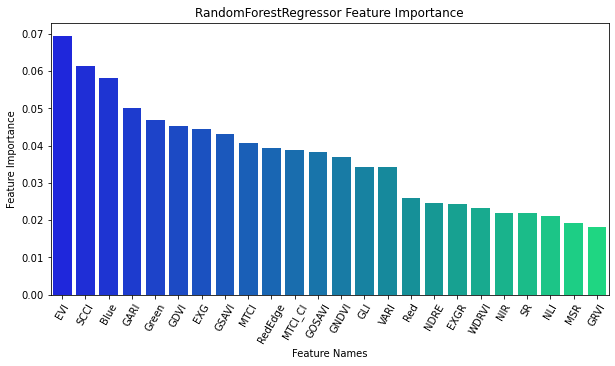

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Graminor_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 51.21 (+/- -1.58)        R2 Test: 0.73 (+/- 0.08)
RMSE Train: 18.99 (+/- -1.36)       R2 Train: 0.96 (+/- 0.01)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


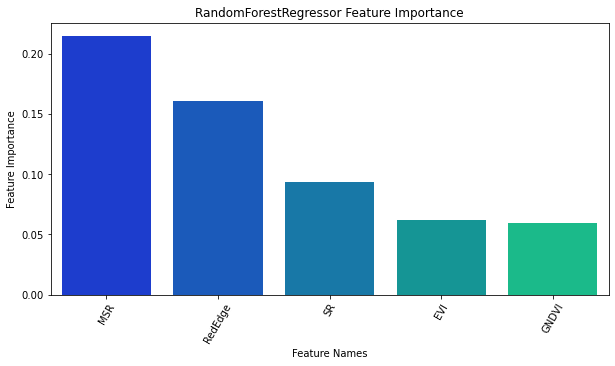

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Masbasis_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 70.49 (+/- -7.68)        R2 Test: 0.28 (+/- 0.27)
RMSE Train: 31.74 (+/- -4.66)       R2 Train: 0.86 (+/- 0.05)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


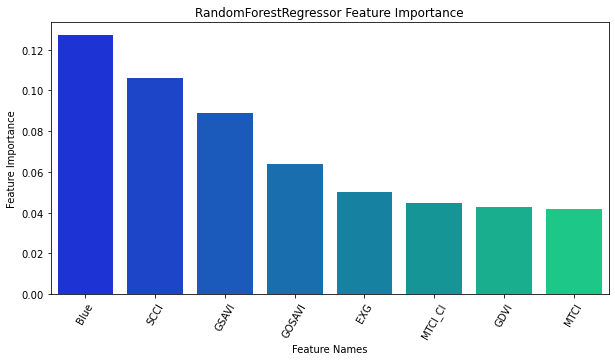

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Masbasis_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 80.78 (+/- -6.42)        R2 Test: 0.28 (+/- 0.10)
RMSE Train: 30.32 (+/- -1.23)       R2 Train: 0.90 (+/- 0.00)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


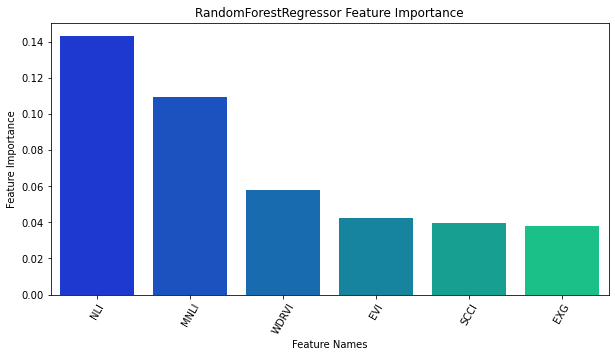

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Robot_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 50.64 (+/- -6.54)        R2 Test: 0.74 (+/- 0.08)
RMSE Train: 18.63 (+/- -2.25)       R2 Train: 0.96 (+/- 0.01)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


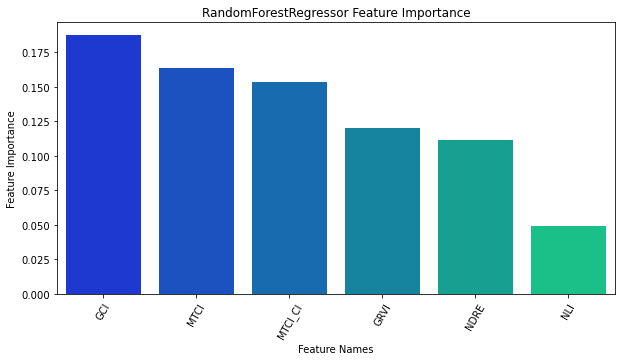

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Staur_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 70.93 (+/- -5.14)        R2 Test: 0.44 (+/- 0.04)
RMSE Train: 26.59 (+/- -1.34)       R2 Train: 0.92 (+/- 0.00)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


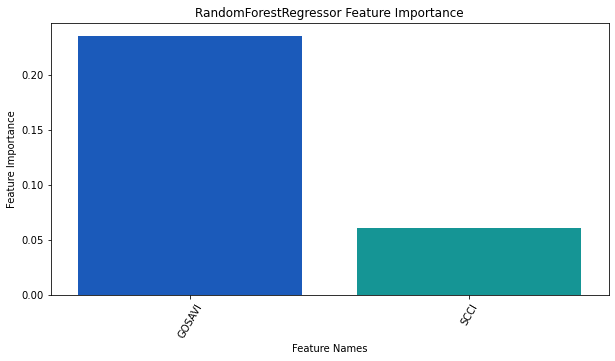

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Staur_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 52.11 (+/- -6.95)        R2 Test: 0.65 (+/- 0.09)
RMSE Train: 19.42 (+/- -0.96)       R2 Train: 0.95 (+/- 0.00)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


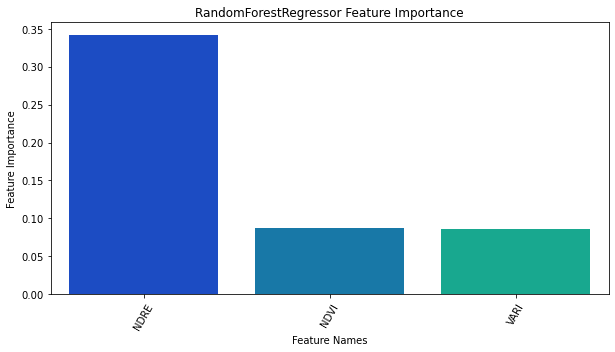

In [185]:
# Iterating through all possible permutations of the fields dataset
for df in all_df_now:
    df_ = locals()[df].copy()

    X = df_[training_features]
    y = df_[target_features].values.ravel()
    groups = df_[group_feature].values.ravel()

    gkf = list(GroupKFold(n_splits=3).split(X, y, groups))
    save_details(df, df, 'same', 'self', agg_method)
    # Getting scores using cross_val_score
    for model in models:
        importances = training_gkf_std(model, X, y, gkf)
        plot_feat_imp(importances, model, training_features, threshold = threshold_all)

### One against all - one2one

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Training:  Graminor_2019_Simps Test:  Graminor_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 134.4048115191609        R2 Test: -0.8161826627819737
RMSE Train: 16.312078322746306       R2 Train: 0.8949396724157687


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


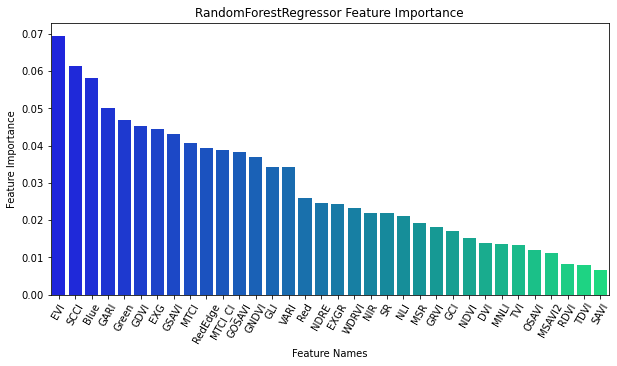

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Training:  Graminor_2019_Simps Test:  Masbasis_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 84.7818029195977        R2 Test: -0.010969680785076319
RMSE Train: 16.312078322746302       R2 Train: 0.8949396724157687


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


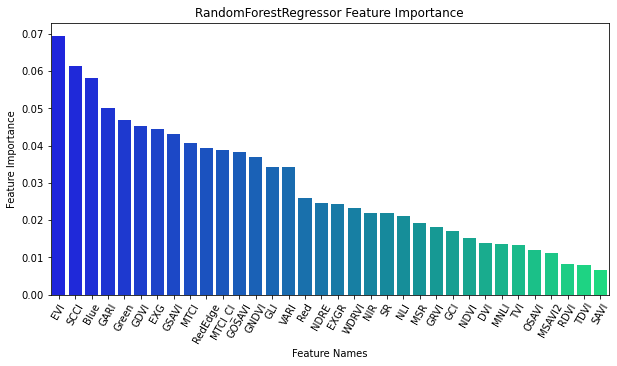

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Training:  Graminor_2019_Simps Test:  Masbasis_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 128.94444633949539        R2 Test: -0.8198142408214759
RMSE Train: 16.312078322746306       R2 Train: 0.8949396724157687


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


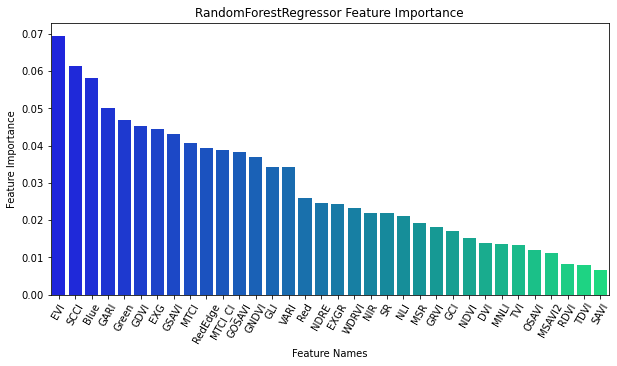

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Training:  Graminor_2019_Simps Test:  Robot_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 102.51960692079598        R2 Test: -0.06143635915349965
RMSE Train: 16.312078322746306       R2 Train: 0.8949396724157687


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 

In [186]:
# Iterating through all possible permutations of the fields dataset

for i in itertools.permutations(all_df_now, 2):
    train_df = locals()[i[0]].copy()
    test_df = locals()[i[1]].copy()
    
    
    X_train = train_df[training_features]
    y_train = train_df[target_features].values.ravel()
    X_test = test_df[training_features]
    y_test = test_df[target_features].values.ravel()
    
    save_details(i[0], i[1], 'same', 'self', agg_method)

    # Getting scores using cross_val_score
    for model in models:
        print('Training: ', i[0],'Test: ', i[1], ' : ', model)
        importances = training_regr(model, X_train, y_train, X_test, y_test)
        if importances is not None:
#             plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)
                plot_feat_imp(importances, model, training_features, threshold=5, sort_feat=True)

### One aganist all together

Graminor_2019_Simps ['Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps', 'Staur_2019_Simps', 'Staur_2020_Simps']
Training: All   Test:  Graminor_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 84.38261959790329        R2 Test: -1.81142279494785
RMSE Train: 24.89467096164037       R2 Train: 0.9545879955529641


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


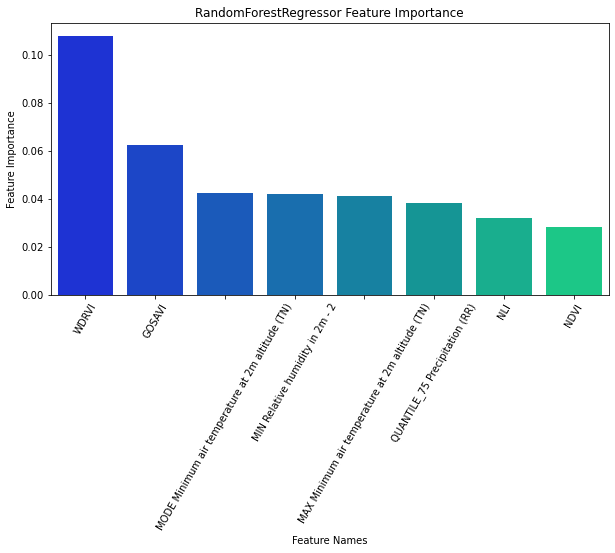

Graminor_2020_Simps ['Graminor_2019_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps', 'Staur_2019_Simps', 'Staur_2020_Simps']
Training: All   Test:  Graminor_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 117.42674718961007        R2 Test: -0.3863214876834169
RMSE Train: 24.875697795807046       R2 Train: 0.9432678710784714


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


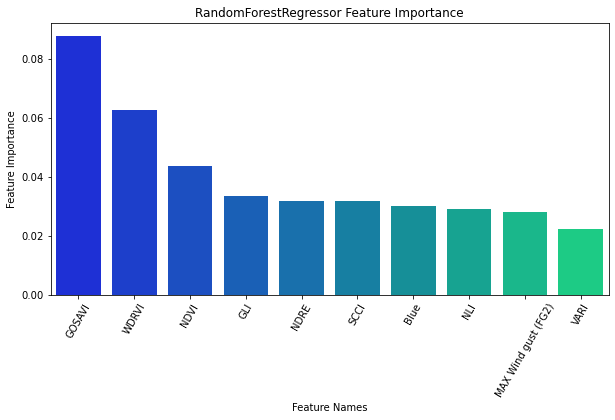

Masbasis_2019_Simps ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2020_Simps', 'Staur_2019_Simps', 'Staur_2020_Simps']
Training: All   Test:  Masbasis_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 90.9423625242222        R2 Test: -0.16322921219094244
RMSE Train: 22.97332942271264       R2 Train: 0.958982624493552


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


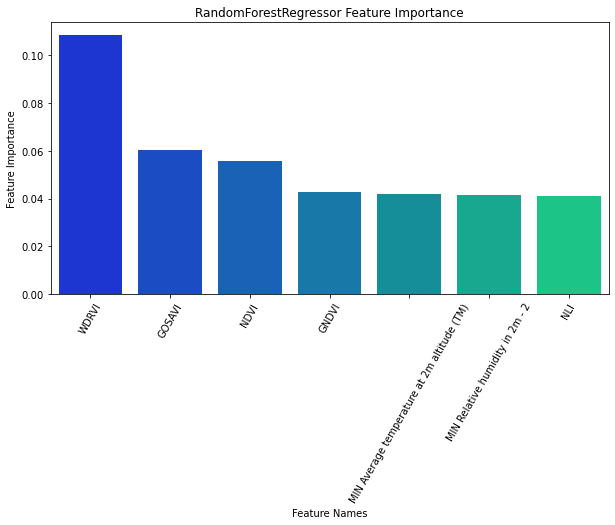

Masbasis_2020_Simps ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Staur_2019_Simps', 'Staur_2020_Simps']
Training: All   Test:  Masbasis_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 136.0584413769468        R2 Test: -1.0261554352194984
RMSE Train: 23.303173786387987       R2 Train: 0.9546360860206343


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


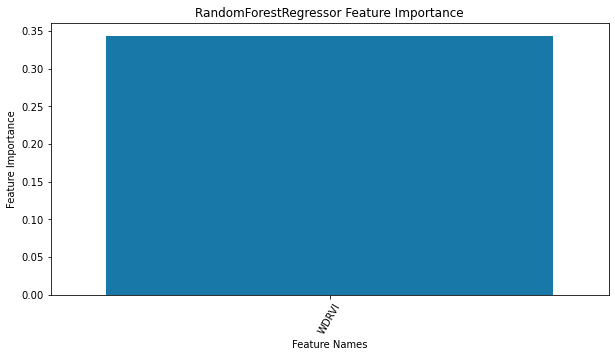

Staur_2019_Simps ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps', 'Staur_2020_Simps']
Training: All   Test:  Staur_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 117.1763922705441        R2 Test: -0.5221742612838136
RMSE Train: 23.12465998455305       R2 Train: 0.9390435607869194


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


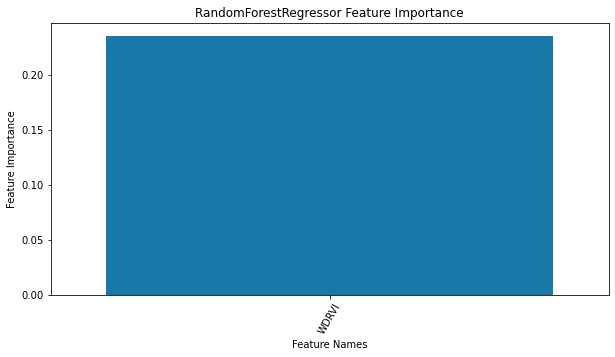

Staur_2020_Simps ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps', 'Staur_2019_Simps']
Training: All   Test:  Staur_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 67.34731971724331        R2 Test: 0.4161993079271572
RMSE Train: 25.171323275608874       R2 Train: 0.9518747426207531


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


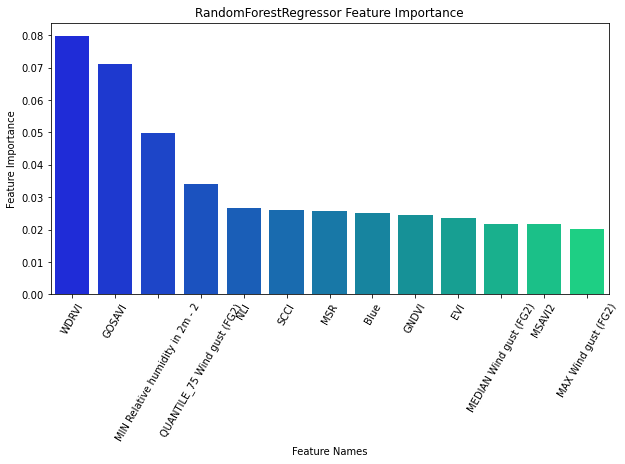

In [187]:
# Iterating through all possible permutations of the fields dataset
for df in all_df_now:
    if 'Robot' not in df:
        temp_list = [x for x in all_df_simps if not 'Robot' in x  if not df in x ]
        print(df, temp_list)

        # Making list of df for conct before training
        train_df_list = []
        for x in temp_list:
            train_df_list.append(locals()[x])

        train_df = pd.concat(train_df_list)
        test_df = locals()[df].copy()

        X_train = train_df[training_features]
        y_train = train_df[target_features].values.ravel()
        X_test = test_df[training_features]
        y_test = test_df[target_features].values.ravel()

        save_details('ALL', df, 'same', all_df_now, agg_method)
        
        # Getting scores using cross_val_score
        for model in models:
            print('Training: All  ','Test: ', df, ' : ', model)
            importances = training_regr(model, X_train, y_train, X_test, y_test)
            if importances is not None:
#                 plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)
                plot_feat_imp(importances, model, training_features, threshold=threshold_all, sort_feat=sorted_all)

### Vollebekk ALL vs Staur ALL

#### Training Staur, Test Vollebekk

Training data: ['Staur_2019_Simps', 'Staur_2020_Simps']
Test data: ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 229.18122488908304        R2 Test: -4.789382661237497
RMSE Train: 23.294666340649226       R2 Train: 0.9541455481153607


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


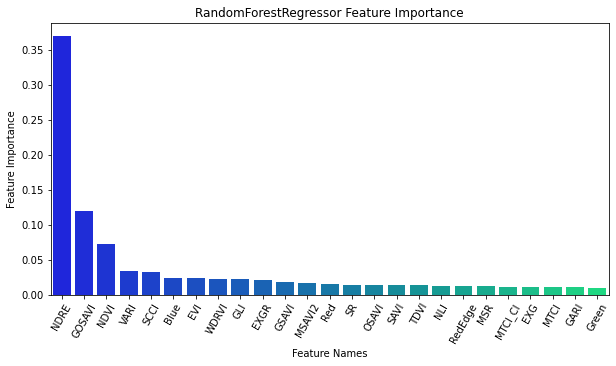

In [189]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Staur', 
                                                   test_field = 'Vollebekk', 
                                                   year = 'all')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

#### Training Vollebekk, Test Staur

Training data: ['Graminor_2019_Simps', 'Graminor_2020_Simps', 'Masbasis_2019_Simps', 'Masbasis_2020_Simps']
Test data: ['Staur_2019_Simps', 'Staur_2020_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 101.7886330083014        R2 Test: 0.12447796270701161
RMSE Train: 24.53484529659728       R2 Train: 0.9336500146315361


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


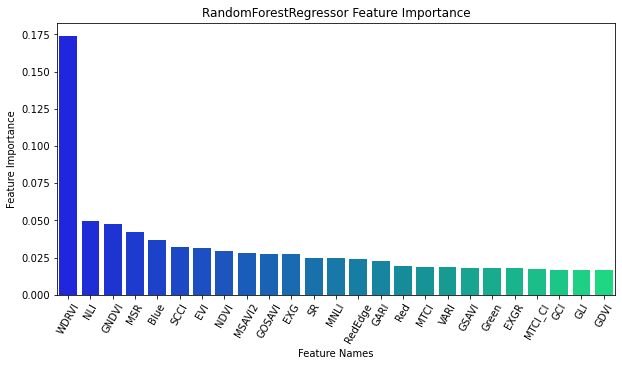

In [190]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Vollebekk', 
                                                   test_field = 'Staur', 
                                                   year = 'all')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

### 2020 Vollebekk vs 2020 Staur

#### Training Staur, Test Vollebekk

Training data: ['Staur_2020_Simps']
Test data: ['Graminor_2020_Simps', 'Masbasis_2020_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 235.41484882171835        R2 Test: -4.714987012518827
RMSE Train: 19.140251840496816       R2 Train: 0.9528459208379715


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


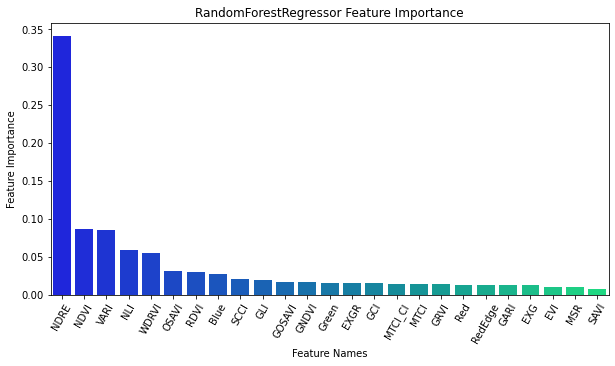

In [191]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Staur', 
                                                   test_field = 'Vollebekk', 
                                                   year = '2020')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

#### Training Vollebekk, Test Staur

Training data: ['Graminor_2020_Simps', 'Masbasis_2020_Simps']
Test data: ['Staur_2020_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 136.0451144537356        R2 Test: -1.3822639206874752
RMSE Train: 24.43957685819219       R2 Train: 0.9384064965728947


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


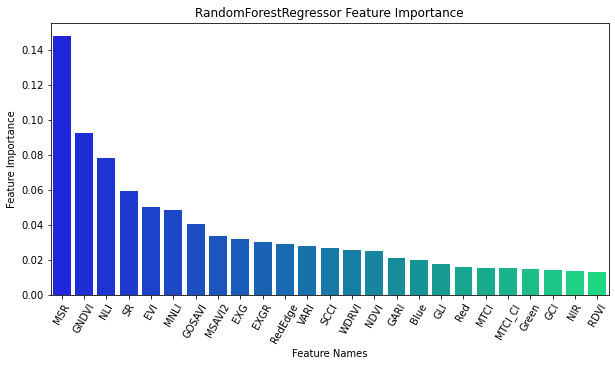

In [192]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Vollebekk', 
                                                   test_field = 'Staur', 
                                                   year = '2020')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

### 2019 Vollebekk vs 2019 Staur

#### Training Staur, Test Vollebekk

Training data: ['Staur_2019_Simps']
Test data: ['Graminor_2019_Simps', 'Masbasis_2019_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 185.45539592307705        R2 Test: -6.348128559099556
RMSE Train: 25.855179429116816       R2 Train: 0.9258895856720823


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


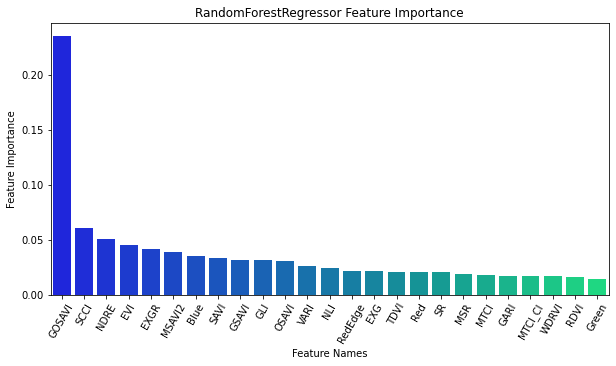

In [193]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Staur', 
                                                   test_field = 'Vollebekk', 
                                                   year = '2019')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

#### Training Vollebekk, Test Staur

Training data: ['Graminor_2019_Simps', 'Masbasis_2019_Simps']
Test data: ['Staur_2019_Simps']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 RMSE Test: 105.93693275290316        R2 Test: -0.24416768769899266
RMSE Train: 25.038829914032373       R2 Train: 0.8660551999529479


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


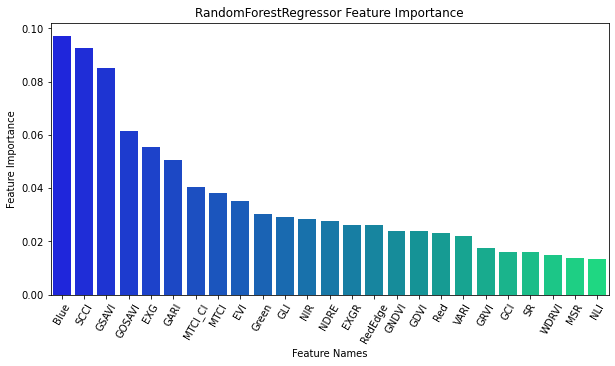

In [194]:
train_str_list, test_str_list = list_test_train_df(all_df_now,
                                                   train_field = 'Vollebekk', 
                                                   test_field = 'Staur', 
                                                   year = '2019')

train_df_list = []
test_df_list = []
for x in train_str_list:
    train_df_list.append(locals()[x])
for x in test_str_list:
    test_df_list.append(locals()[x])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()

# Getting scores using cross_val_score
for model in models:
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
        plot_feat_imp(importances, model, training_features, threshold='Top_25', sort_feat=sorted_all)

###

###

In [ ]:
DONE

### GroupKFold

###

In [ ]:
# Iterating through all possible permutations of the fields dataset
results = []
for i in itertools.permutations(all_df_simps, 2):

#     train_df = locals()[i[0]].copy()
#     test_df = locals()[i[1]].copy()

    train_size = 0.7*locals()[i[0]].shape[0]
    
    train_df = locals()[i[0]].copy()
    test_df = locals()[i[1]].copy()
    
    print(f"Train dataset: {i[0]} {train_df['GrainYield'].isna().sum()}\
    \n Test dataset: {i[1]} {test_df['GrainYield'].isna().sum()}")
    print('=>')
#     print(f"Missing values in {i[0]} {train_df['GrainYield'].isna().sum()}\
#     \n Missing values in {i[1]} {test_df['GrainYield'].isna().sum()}")
    # Dropping entries with grainyield missing
    train_df.dropna(subset=['GrainYield'], inplace=True)
    test_df.dropna(subset=['GrainYield'], inplace=True)

    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
    X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
    features = X_train.columns

    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    for model in models:
        print(model)
        acc, acc_std, imp = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
#         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
        print('=============================================')

In [ ]:
train_dfs = [x[0] for x in results]
test_dfs = [x[1] for x in results]
modelss = [x[2] for x in results]
acc_normal = [x[3] for x in results]
acc_stds = [x[4] for x in results]
imp_normal = [x[5] for x in results]
imp_stds = [x[6] for x in results]
# acc_normal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = train_dfs, test_dfs
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
# xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [ ]:
model = RandomForestRegressor(n_estimators = 1000, max_depth=250, min_samples_split=5, random_state=0, n_jobs = -1)
model = RandomForestRegressor(n_estimators = 50, max_depth=100, min_samples_split=400, random_state=0, n_jobs = -1)


## Several Models: To clean

In [ ]:
#==============================================================================
# Ridge
#==============================================================================
from sklearn.linear_model import Ridge
model = Ridge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*1. for x in range(1,10)],
                  'model__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# Lasso
#==============================================================================
from sklearn.linear_model import Lasso
model = Lasso()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__selection' : ['cyclic','random']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ElasticNet
#==============================================================================
from sklearn.linear_model import ElasticNet
model = ElasticNet()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__l1_ratio' : [x*0.1 for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# OrthogonalMatchingPursuit
#==============================================================================
from sklearn.linear_model import OrthogonalMatchingPursuit
model = OrthogonalMatchingPursuit()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__fit_intercept' : [True, False],
                  'model__n_nonzero_coefs' : [x for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# BayesianRidge
#==============================================================================
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
                  'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_2' : [1.0]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ARDRegression
#==============================================================================
from sklearn.linear_model import ARDRegression
model = ARDRegression()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
#                       'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [0.01],
                  'model__lambda_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__verbose' : [True]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# RANSACRegressor
#==============================================================================
from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__min_samples' : [x/.1 for x in range(1, 10)],
                  'model__max_trials' : [x for x in range(1, 500,50)],
                  'model__loss' : ['absolute_loss', 'squared_loss']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# TheilSenRegressor
#==============================================================================
# from sklearn.linear_model import TheilSenRegressor
# model = TheilSenRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__max_subpopulation' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
#                   'model__n_subsamples' : [x for x in range(9, 1300,50)],
#                   'model__max_iter' :  [x for x in range(50, 1000, 50)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
#==============================================================================
# HuberRegressor
#==============================================================================
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__epsilon' : [x/.01 for x in range(100, 200, 5)],
                  'model__alpha' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# DecisionTreeRegressor
#==============================================================================
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__max_depth' : [None]+[x for x in range(1, 100,5)],
                  'model__min_samples_leaf' : [x for x in range(1, 50,5)],
                  'model__min_samples_split' : [2]+[x for x in range(1, 50,5)],
                  'model__max_features' : [x for x in range(1, 10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# GaussianProcessRegressor
#==============================================================================
from sklearn.gaussian_process import GaussianProcessRegressor
model = GaussianProcessRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__kernel' : [None]+['rbf', 'sigmoid',  'linear', 'poly'],
                  'model__alpha' : [x*0.0000000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# KNeighborsRegressor
#==============================================================================
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_neighbors' : [x for x in range(1, 100,5)],
                  'model__weights' : ['uniform', 'distance'],
                  'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'model__leaf_size' : [x for x in range(10, 50, 5)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
# #==============================================================================
# # RadiusNeighborsRegressor
# #==============================================================================
# from sklearn.neighbors import RadiusNeighborsRegressor
# model = RadiusNeighborsRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # RandomForestRegressor
# #==============================================================================
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # SVR
# #==============================================================================
# from sklearn.svm import SVR
# model = SVR()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)

t_end = time.time()
tt = t_end - t_start
time_taken.append(tt)
print('Total time complete: ', (tt) / 60, 'minutes')

## Gradient Boosting Regressor Grid Search Params

In [ ]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')

comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 10
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']


#==============================================================================
# GradientBoostingRegressor
#==============================================================================
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__loss' : ['ls', 'lad', 'huber', 'quantile'],
# #                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
# #                   'model__n_estimators' : range(0,500, 100),
                  
# #                   'model__max_depth':range(5,16,2), 
# #                   'model__min_samples_split':range(200,1100, 200), # 2100
# #                   'model__min_samples_leaf':range(30,71,10),
#                   'model__max_features':range(7,20,2),
#                   'model__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}]

param_grid   =  [{'model__loss' : ['huber'],
#                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
#                   'model__n_estimators' : range(0,500, 100),
                  
                  'model__max_depth':range(5,16,2), 
#                   'model__min_samples_split':range(2,5), # 2100
#                   'model__min_samples_leaf':range(1,2),
#                   'model__max_features':range(5,6),
                  'model__subsample':[0.7,0.8]}]
# pipe.get_params()
estimator = pipe

for score in scores:
    grid(Xtrain = X.values,
                ytrain = y.values,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

## Random Forest Grid Search Params

In [ ]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')
comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 5
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

#==============================================================================
# RandomForestRegressor
#==============================================================================
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {
    'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}


estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

## Permutation importance

In [ ]:


# PERMUTATION

from sklearn.inspection import permutation_importance


result = permutation_importance(gs_xgb_fitted, X_test, y_test, n_repeats=100, random_state=0)

# ==================================
# Feature selection
# ===================================

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Plot importances
fig, ax = plt.subplots(figsize=(25, 25))
ind = indices = np.argsort(result.importances_mean)[::-1]
plt.barh(X_test.columns, result.importances_mean[ind])
plt.show()


In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}
grid_search_rfc = GridSearchCV(rfc, param_grid = grid_values, scoring = scoring, refit='f1')
grid_search_rfc.fit(x_train, y_train)

grid_search_rfc.best_params_
grid_search_rfc.cv_results_

# cv_results[‘mean_test_<metric_name>’]
grid_search_rfc.cv_results_['mean_test_recall']


## List of models

In [ ]:
models = [GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500),
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1),
         Lasso(alpha= 4.5),
        ]
         


In [ ]:
for df in all_df:
    
    
    temp_df = locals()[df].copy()
    #==============================================================================
    # Dropping rows with missing values
    #==============================================================================

    temp_df.dropna(subset=['GrainYield'], inplace=True)
    #==============================================================================
    # Split dataframe into data and target
    #==============================================================================
    X = temp_df[[x for x in temp_df.columns if x not in yield_cols+id_cols_new]]
    y = temp_df['GrainYield']
    
    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=55)
    
    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    #==============================================================================
    # Correlation heatmap of indices with target_cols
    #==============================================================================
#     sns.diverging_palette(331, 129, as_cmap=True)

#     pal=['PRGn', 'PiYG', 'PuOr', 'RdBu','RdYlBu','RdYlGn','Spectral']

#     correlation = temp_df.iloc[:,1:].corr()
#     matrix = np.triu(correlation)

#     plt.figure(figsize=(10,6))
#     plt.title(df)
#     sns.heatmap(correlation, cmap='PRGn', annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0 ,square=True, mask=matrix)
#     # plt.savefig('Data/heatmap.pdf',dpi=500, bbox_inches='tight')
#     plt.show()


    #==============================================================================
    # Predictions
    #==============================================================================

    param=[x/10 for x in range(25,100)]
    param=[x for x in range(0,1000, 100)]
    param=[1]
    for pr in tqdm(param):
        for model in models:
            R2 = []
            RMSE=[]
            MAE=[]
            for rs in range(10):
                #==============================================================================
                # Create separate train/test splits
                #==============================================================================
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
                X_train.reset_index(drop=True, inplace=True)
                X_test.reset_index(drop=True, inplace=True)
                sc = StandardScaler()
                sc.fit(X_train)
                X_train_std = sc.transform(X_train)
                X_test_std = sc.transform(X_test)
                #==============================================================================
                # Training best performing models
                #==============================================================================
    #             model = Lasso(alpha= 4.5)
                model.fit(X_train_std, y_train)
                y_pred = model.predict(X_test_std)
                R2.append(r2_score(y_test, y_pred))
                MAE.append(mean_absolute_error(y_test, y_pred))
                RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
            accuracy = {}
            accuracy['R2'] = R2
            accuracy['MAE'] = MAE
            accuracy['RMSE'] = RMSE
            scores={}
            for k, s in accuracy.items():
                scores[k]=(sum(s)/len(s))
            print(df, model)
            print(scores)


In [ ]:
for model in models:
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    print(y_pred)

In [ ]:
plot_feature_importance(model.feature_importances_,X_train.columns,'Gradient Boosting Regressor')


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
y.isna()

## Restart the kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")